In [1]:
# MOUNT GOOGLE DRIVE OVER GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# MOVE INTO THE ROOT DIRECTORY FOR THE PROJECT
%cd drive/MyDrive/PConv_Image_Inpainting/

/content/drive/MyDrive/PConv_Image_Inpainting


In [3]:
# CLEAR THE CHECKPOINTS
!rm -rf ckpt

In [4]:
# INSTALL THE REQUIREMENTS
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.7/726.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

### Prepare the Dataset and Train the Model

In [5]:
import opendatasets as od

dataset_url = "https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sarvasva309
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset


In [6]:
# PREPARE THE DATASET
!python src/prepare_dataset.py --train_crop_size 256 --val_crop_size 256

✅ Dataset moved and cleaned up.

📂 Splitting & renaming: 100% 17/17 [06:38<00:00, 23.46s/it]
✅ Dataset split complete.

✅ 22572 images retained in data/data_256

✅ 2508 images retained in data/val_256

⌛ Generating 22572 masks in 'data/mask'
✅ Mask generation complete.

⌛ Generating 2508 masks in 'data/val_mask'
✅ Mask generation complete.

✅ Masks generated.



In [9]:
# START THE TRAINING
!python experiment.py

Check Point is 'ckpt/0424_1622_51'
Loading the Model...
Loading the Validation Dataset...
Loading the Training Dataset...
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Start the training
Epoch Number: 1
[STEP:      0] | Valid Loss: 0.313091 | Hole Loss: 0.165454| TV Loss: 0.200506 | Perc Loss: 19.287510| Style Loss: 0.783308 | Total Loss: 96.287224

⌛ Evaluating the Model

🔍 Running PSNR and SSIM evaluation on entire validati

### Testing the Model on Various Images

In [128]:
# A RESPRESENTATIVE OF COMMAND-LINE ARGUMENTS
import os
import random
from argparse import Namespace

# Define paths to validation image and mask folders
val_img_dir = "examples/data"
val_mask_dir = "examples/masks"

# Get list of image and mask filenames
val_images = [f for f in os.listdir(val_img_dir) if f.lower().endswith(('.jpg', '.png'))]
val_masks = [f for f in os.listdir(val_mask_dir) if f.lower().endswith('.png')]

# Randomly select one from each
selected_img = random.choice(val_images)
selected_mask = random.choice(val_masks)
args = Namespace(
    img=os.path.join(val_img_dir, selected_img),
    mask=os.path.join(val_mask_dir, selected_mask),
    model="model.pth",
    resize=False,
    gpu_id=0
)

In [13]:
import argparse
from distutils.util import strtobool
import os

from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from src.model import PConvUNet

In [14]:
device = torch.device(f"cuda:{args.gpu_id}" if torch.cuda.is_available() else "cpu")

In [15]:
!pwd

/content/drive/MyDrive/PConv_Image_Inpainting


In [86]:
# DEFINE THE MODEL
print("Loading the Model...")
model = PConvUNet(finetune=False, layer_size=7)
model.load_state_dict(torch.load(args.model, map_location=device)['model'])
model.to(device)
model.eval()
print("Model Loaded Successfully!")

Loading the Model...
Model Loaded Successfully!


In [129]:
# INPUT IMAGE AND MASK LOADING WITH VISUALIZATION

import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image

print("Loading the inputs...")

# LOAD INPUT IMAGE AND CONVERT TO TENSOR
org = Image.open(args.img).convert('RGB')
org = TF.to_tensor(org)

# LOAD MASK AND CONVERT TO TENSOR
mask = Image.open(args.mask).convert('RGB')
mask = TF.to_tensor(mask)

print("Inputs Loaded Successfully!")

# CREATE MASKED IMAGE
inp = org * mask

# CONVERT TENSORS TO PIL_IMAGE FOR VISUALIZATION
org_pil = TF.to_pil_image(org)
mask_pil = TF.to_pil_image(mask)
masked_pil = TF.to_pil_image(inp)

Loading the inputs...
Inputs Loaded Successfully!


In [130]:
# GENERATING THE INPAINTED IMAGE

import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Model Prediction
print("Model Prediction...")
with torch.no_grad():
    inp_ = inp.unsqueeze(0).to(device)     # [1, 3, H, W]
    mask_ = mask.unsqueeze(0).to(device)   # [1, 3, H, W]

    if args.resize:
        org_size = inp_.shape[-2:]
        inp_ = F.interpolate(inp_, size=256)
        mask_ = F.interpolate(mask_, size=256)

    raw_out, _ = model(inp_, mask_)

    if args.resize:
        raw_out = F.interpolate(raw_out, size=org_size)
print("Model Prediction Successful!")

Model Prediction...
Model Prediction Successful!


In [131]:
# FINAL OUTPUT

# Post process
raw_out = raw_out.to(torch.device('cpu')).squeeze()
raw_out = raw_out.clamp(0.0, 1.0)
out = mask * inp + (1 - mask) * raw_out

# Convert model output to PIL image
output_tensor = out.squeeze(0).cpu().clamp(0, 1)  # Ensure valid image range [0,1]
output_pil = TF.to_pil_image(output_tensor)

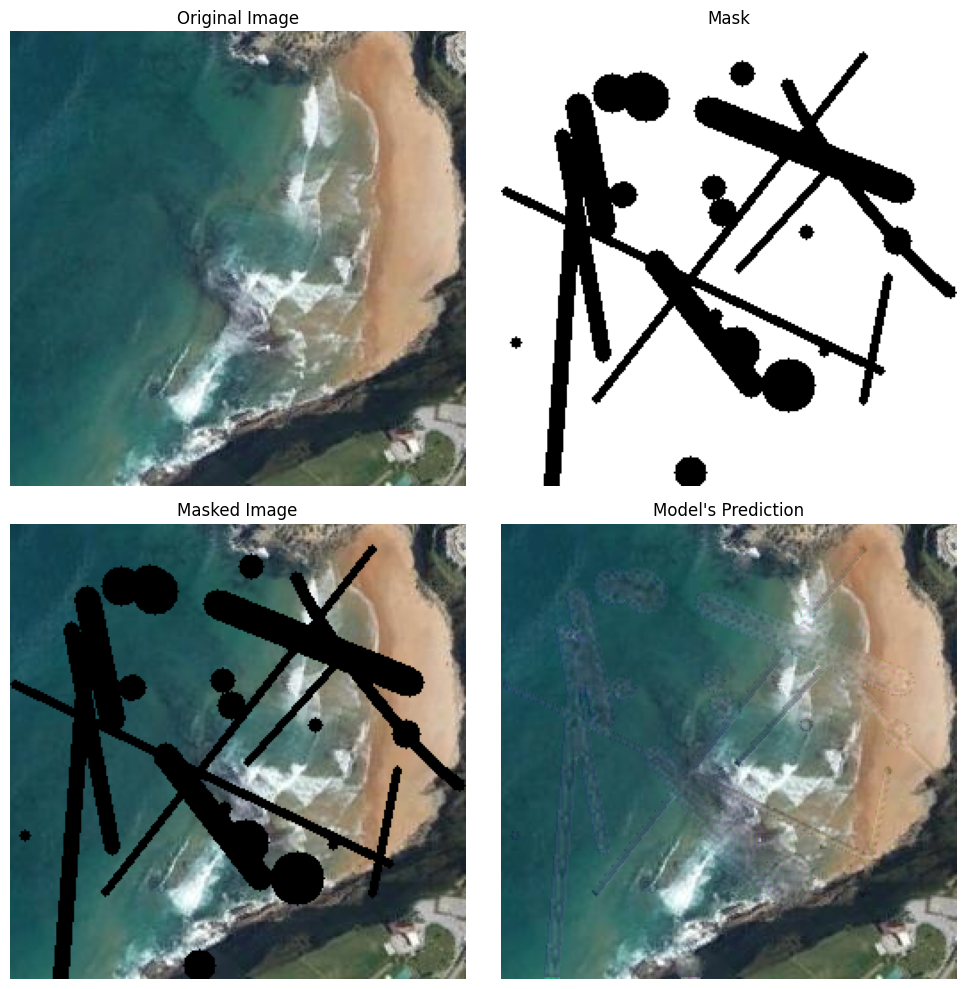

In [132]:
# DISPLAY ALL THE IMAGES IN A 2x2 GRID
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjusted figure size

# METHOD TO DISPLAY IMAGE
def show_image(ax, image, title):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

# Flatten axs for easy indexing (since axs is a 2D array now)
axs = axs.flatten()

show_image(axs[0], org_pil, "Original Image")
show_image(axs[1], mask_pil, "Mask")
show_image(axs[2], masked_pil, "Masked Image")
show_image(axs[3], output_pil, "Model's Prediction")

plt.tight_layout()
plt.show()

In [ ]:
# Saving an output image
print("Saving the output...")
out = TF.to_pil_image(out)
img_name = args.img.split('/')[-1]

output_path = os.path.join("examples", "out_{}".format(img_name))
out.save(output_path)

print("Output Saved Successfully!")
print(f"Output Path: {output_path}")